In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [10]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10)
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_36479/257424618.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Load Data

In [2]:
def parse(dataname: str, suffix=".log"):
    """
    dataname is <name>_<scale>.log
    where <name> can be any letter and `_` ,`-`
    return <name>, <scale>
    """
    dataname = dataname.removesuffix(suffix)
    scale = int(dataname.split("_")[-1])
    name = dataname.removesuffix("_"+str(scale))
    name = name.split("/")[-1]
    return name, scale

def load_domain_info():
    res = {}
    domains = ["bgmaps", "dao", "iron", "maze512", "random10", "starcraft", "street", "rooms"]
    for domain in domains:
        maps = os.listdir("../maps/%s" % domain)
        for m in maps:
            res[os.path.basename(m).removesuffix(".map")] = domain
    return res

dm_info = load_domain_info()
def load_df(pth):
    print("load file:", pth)
    fname = pth.split("/")[-1]
    df = pd.read_csv(pth, sep="\t")
    name, scale = parse(fname)
    if "scnt" not in df.columns:
        df["scnt"] = 0
    df["map"] = name
    df["scale"] = scale
    df["scnt"] += 1
    df["domain"] = df.apply(lambda x: dm_info.get(x["map"], "unkown"), axis=1)
    # df["preproc"] /= float(df.shape[0])
    return df

In [30]:
print (parse("shanghnai_0_256_8.log"))
print (parse("maze512-16-4_3.log"))

('shanghnai_0_256', 8)
('maze512-16-4', 3)


In [44]:
# dname = "nectar-output/"
dname = "output/"
rect_files = [dname+"rect/"+i for i in os.listdir(dname+"rect")]
# jps2_files = [dname+"jps2/"+i for i in os.listdir(dname+"jps2")]
jps_files = [dname+"jps/"+i for i in os.listdir(dname+"jps")]
rect = pd.concat([load_df(i) for i in rect_files if os.stat(i).st_size])
# jps2 = pd.concat([load_df(i) for i in jps2_files if os.stat(i).st_size])
jps = pd.concat([load_df(i) for i in jps_files if os.stat(i).st_size])

load file: output/rect/maze512-32-0_6.log
load file: output/rect/scene_sp_endmaps_3.log
load file: output/rect/64room_000_7.log
load file: output/rect/GreenerPastures_4.log
load file: output/rect/Denver_2_1024_8.log
load file: output/rect/GreenerPastures_2.log
load file: output/rect/scene_sp_endmaps_5.log
load file: output/rect/64room_000_1.log
load file: output/rect/64room_000_6.log
load file: output/rect/maze512-32-0_1.log
load file: output/rect/GreenerPastures_5.log
load file: output/rect/64room_000_5.log
load file: output/rect/scene_sp_endmaps_1.log
load file: output/rect/maze512-32-0_8.log
load file: output/rect/maze512-32-0_2.log
load file: output/rect/scene_sp_endmaps_6.log
load file: output/rect/64room_000_4.log
load file: output/rect/GreenerPastures_3.log
load file: output/rect/GreenerPastures_8.log
load file: output/rect/Denver_2_1024_2.log
load file: output/rect/maze512-32-0_7.log
load file: output/rect/scene_sp_cha_02_1.log
load file: output/rect/scene_sp_endmaps_2.log
load

# Merge DataFrames

In [45]:
t = jps[["id", "alg", "map", "domain", "scale", "expanded", "nanos", "pcost"]]
t1 = pd.DataFrame.merge(rect, t, on=["id", "map", "domain", "scale"], suffixes=("", "_jps"))
t2 = pd.DataFrame.merge(jps, t, on=["id", "map", "domain", "scale"], suffixes=("", "_jps"))
df = pd.concat([t1, t2])
# add extra columns
df["expd_nano"] = df["nanos"] / df["expanded"]
df["expd_ratio"] = df["expanded_jps"] / df["expanded"]
df["nano_ratio"] = df["nanos_jps"] / df["nanos"]
# sanity checking
(df["pcost"] - df["pcost_jps"]).describe()

count    222816.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

# Improvement on expansion

* The 1st figure shows that both `convrect` and `rect` have less node expansion (`>1` means less expansion than jps).

* The 2nd figure shows that such improvement is not depend on the difficulty of the query (assuming harder query has larger expansion).

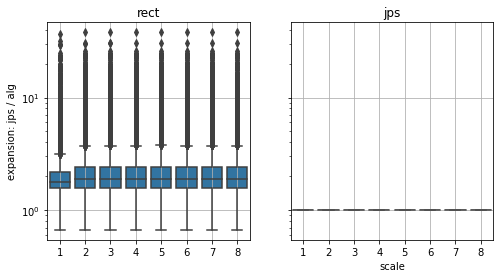

In [28]:
# t = df[df["alg"] != "jps"]
t = df.copy()

names = t["alg"].unique()
# names = t["domain"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=True, sharey=True, figsize=(4*num, 4))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    sns.boxplot(x="scale", y="expd_ratio", color=colors[i], data=t[t["alg"] == names[i]], ax=axes[i])

    axes[i].grid()
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_yscale("log")
    axes[i].set_title(names[i])

axes[0].set_ylabel("expansion: jps / alg")
axes[num // 2].set_xlabel("scale")

plt.savefig("./output/figs/impv_expd.png")

In [55]:
t.groupby("alg")["expd_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
alg,,,,,,,,
convrect,115408.0,2.857715,2.164205,1.000000,1.741845,2.317073,3.243243,45.5
rect,115408.0,2.213436,1.524024,0.666667,1.567568,1.833591,2.375000,38.0


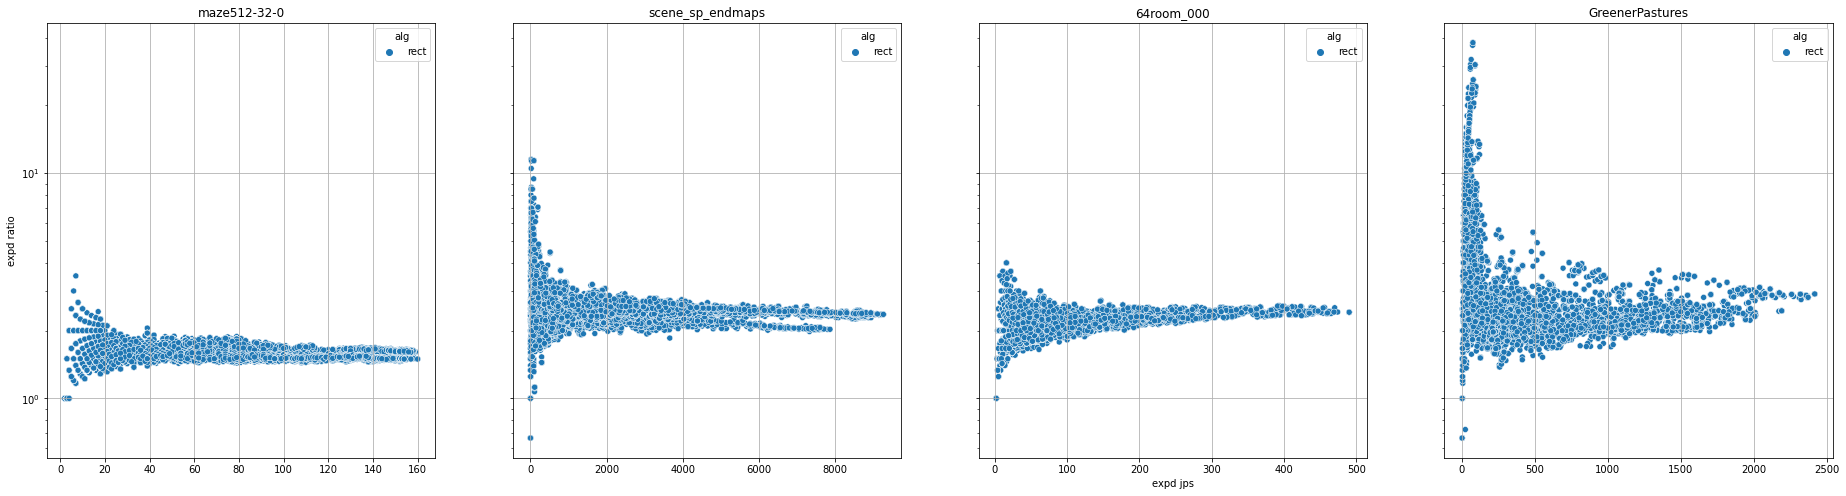

In [29]:
t = df[df["alg"] != "jps"]

names = t["map"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=False, sharey=True, figsize=(8*num, 8))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    sns.scatterplot(data=t[t["map"] == names[i]], x="expanded_jps", y="expd_ratio",hue="alg", ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])

axes[0].set_ylabel("expd ratio")
axes[num // 2].set_xlabel("expd jps")

plt.savefig("./output/figs/impv_expd_2.png")

# Cost of each expansion

Evaluate the cost of each expansion by `nanos / expansion`. Figure and the 1st table below shows:
* `convrect` is about 3.8 times slower than `jps`,
* `rect` is about 2.6 times slower than `jps`.

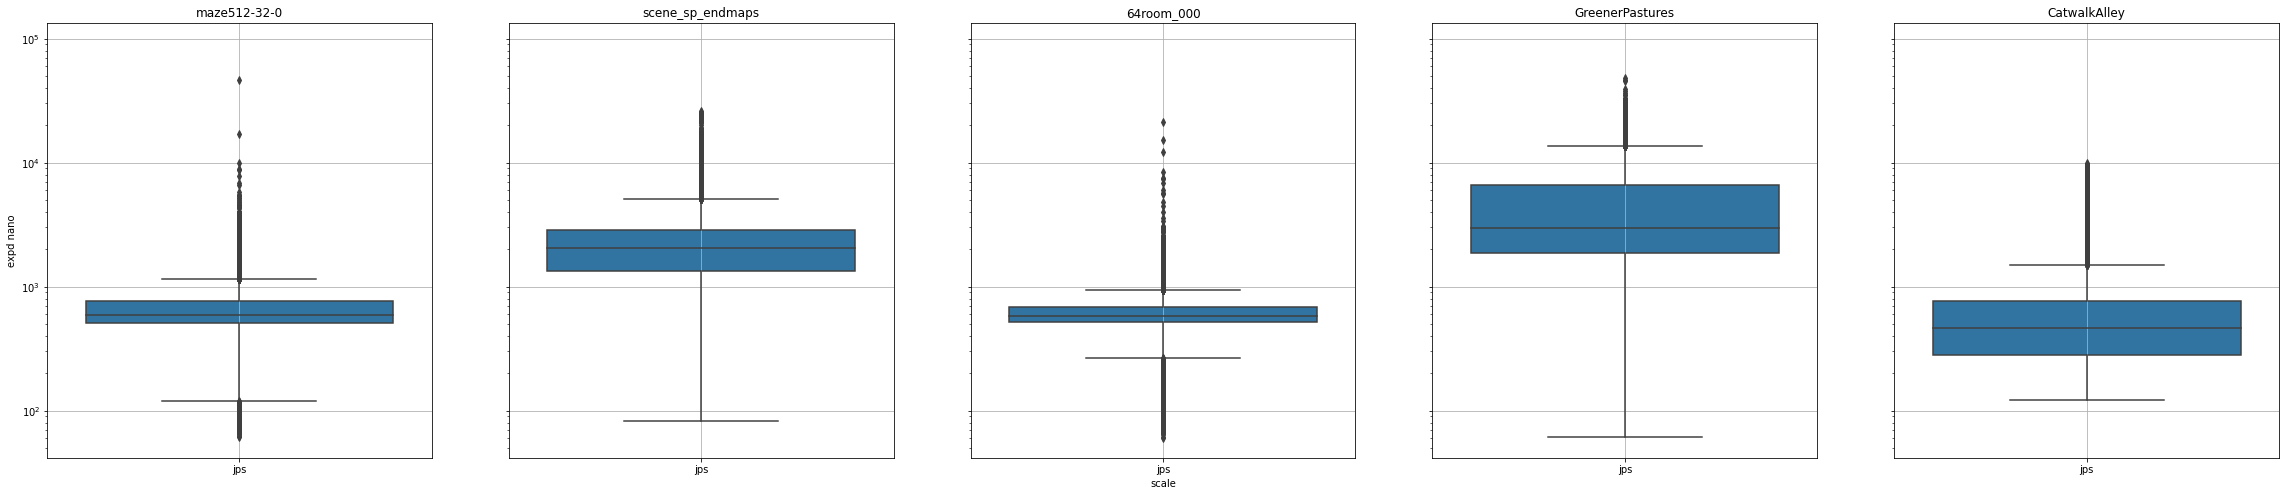

In [27]:
# g = sns.boxplot(data=df, x="alg", y="expd_nano")
# g.set(yscale="log")
names = df["map"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=True, sharey=True, figsize=(8*num, 8))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    # sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])
    sns.boxplot(data=df[df["map"] == names[i]], x="alg", y="expd_nano",ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])

axes[0].set_ylabel("expd nano")
axes[num // 2].set_xlabel("scale")
plt.savefig("./output/figs/expd_cost.png")

In [17]:
df.groupby("alg")["expd_nano"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
alg,,,,,,,,
convrect,128520.0,3359.71,3984.98,120.50,1573.16,2472.02,3700.00,79038.5
jps,128520.0,2663.21,3252.57,68.44,523.62,1383.27,3875.81,83142.0
rect,128520.0,1700.02,2535.46,63.50,538.12,800.79,1748.11,40235.5


In [47]:
df[df["map"] == "CatwalkAlley"]

,id,alg,expanded,inserted,updated,touched,surplus,nanos,pcost,plen,...,map,scale,domain,alg_jps,expanded_jps,nanos_jps,pcost_jps,expd_nano,expd_ratio,nano_ratio
0,0,jps,96,102,0,101,6,97027.0,2934.73,24,...,CatwalkAlley,6,starcraft,jps,96,97027.0,2934.73,1010.697917,1.0,1.0
1,1,jps,2666,2788,78,3234,122,1840040.0,5929.47,245,...,CatwalkAlley,6,starcraft,jps,2666,1840040.0,5929.47,690.187547,1.0,1.0
2,2,jps,30,38,0,37,8,76966.0,2669.03,15,...,CatwalkAlley,6,starcraft,jps,30,76966.0,2669.03,2565.533333,1.0,1.0
3,3,jps,2071,2123,42,2314,52,1121300.0,5650.04,454,...,CatwalkAlley,6,starcraft,jps,2071,1121300.0,5650.04,541.429261,1.0,1.0
4,4,jps,11,18,0,17,7,49878.0,2697.79,9,...,CatwalkAlley,6,starcraft,jps,11,49878.0,2697.79,4534.363636,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115403,995,jps,40,46,0,45,6,42475.0,2603.04,22,...,CatwalkAlley,5,starcraft,jps,40,42475.0,2603.04,1061.875000,1.0,1.0
115404,996,jps,3562,3624,68,4147,62,1290240.0,5113.21,561,...,CatwalkAlley,5,starcraft,jps,3562,1290240.0,5113.21,362.223470,1.0,1.0
115405,997,jps,30,37,0,36,7,39215.0,2419.56,15,...,CatwalkAlley,5,starcraft,jps,30,39215.0,2419.56,1307.166667,1.0,1.0
115406,998,jps,20,27,0,26,7,55944.0,2398.30,15,...,CatwalkAlley,5,starcraft,jps,20,55944.0,2398.30,2797.200000,1.0,1.0


/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


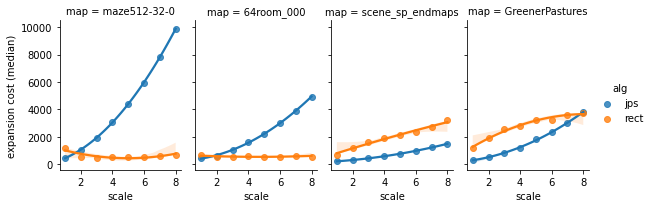

In [60]:
x = df[df["map"] != "CatwalkAlley"].groupby(["alg", "scale", "map"])["expd_nano"].describe().round(2)
g = sns.lmplot(data=x.reset_index(), x="scale", y="50%", order=2, hue="alg", col="map", height=3, aspect=0.7,
col_order=["maze512-32-0", "64room_000", "scene_sp_endmaps", "GreenerPastures"])
g.set_ylabels("expansion cost (median)")
plt.savefig("./output/figs/expd_cost_scale.png")

# Plot Speed-up

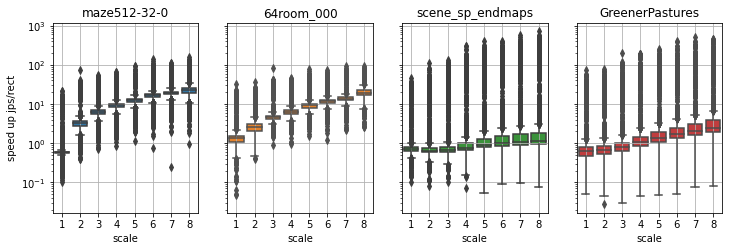

In [71]:
t = df[df["alg"] == "rect"][["nano_ratio", "map", "scale"]]
names = t["map"].unique()
# names = t["domain"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=True, sharey=True, figsize=(3*num, 3.5))
if num == 1:
    axes = [axes]
colors = sns.color_palette()
names = ["maze512-32-0", "64room_000", "scene_sp_endmaps", "GreenerPastures"]

for i in range(num):
    # sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["domain"] == names[i]], ax=axes[i])
    sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])
    axes[i].set_xlabel("scale")

axes[0].set_ylabel("speed up jps/rect")
plt.savefig("./output/figs/speed_rect.png")

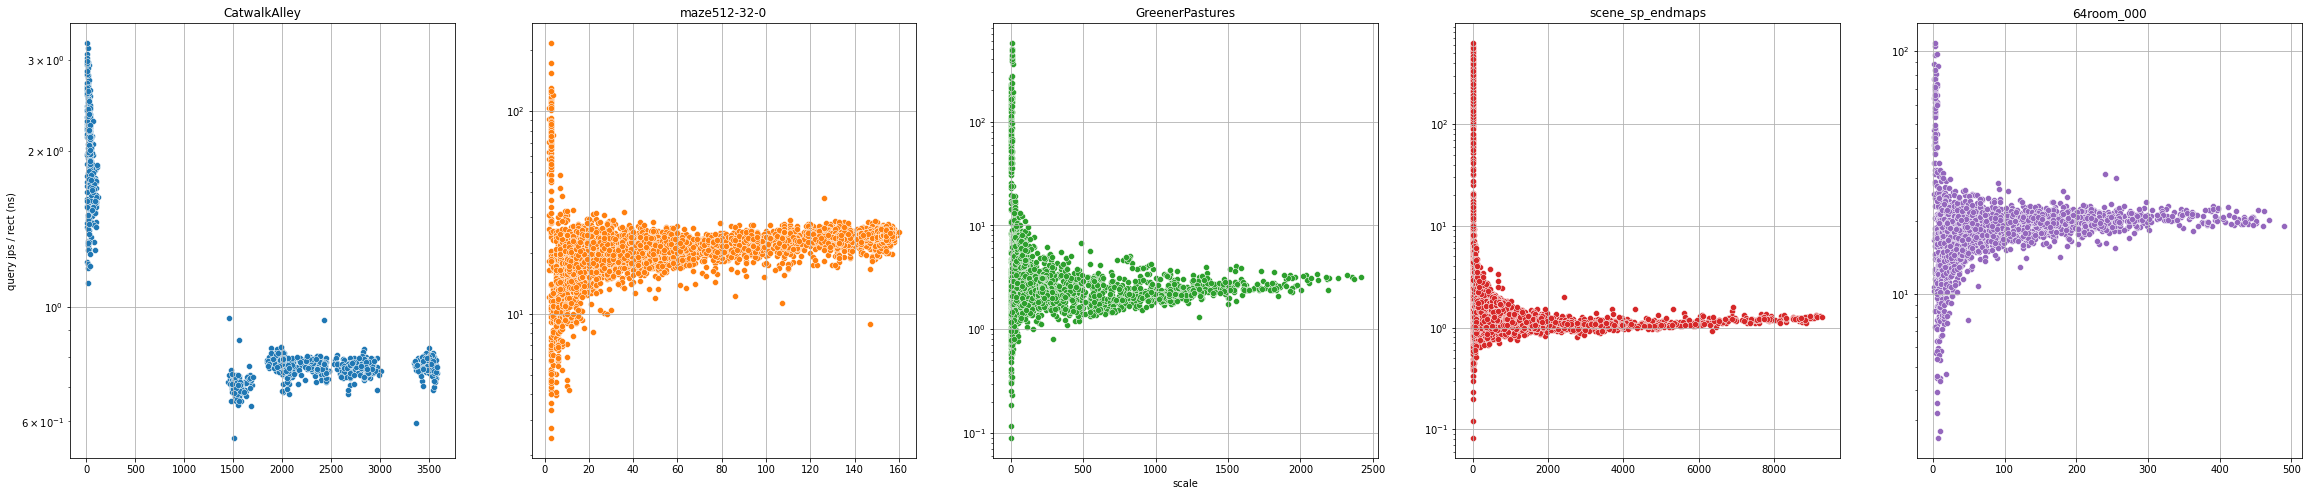

In [101]:
t = df[(df["alg"] == "rect") & (df["scale"] == 8)][["nano_ratio", "map", "scale", "expanded_jps"]]
names = t["map"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=False, sharey=False, figsize=(8*num, 8))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    sns.scatterplot(x="expanded_jps", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])

axes[0].set_ylabel("query jps / rect (ns)")
axes[num // 2].set_xlabel("scale")
plt.savefig("./output/figs/dist_rect.png")

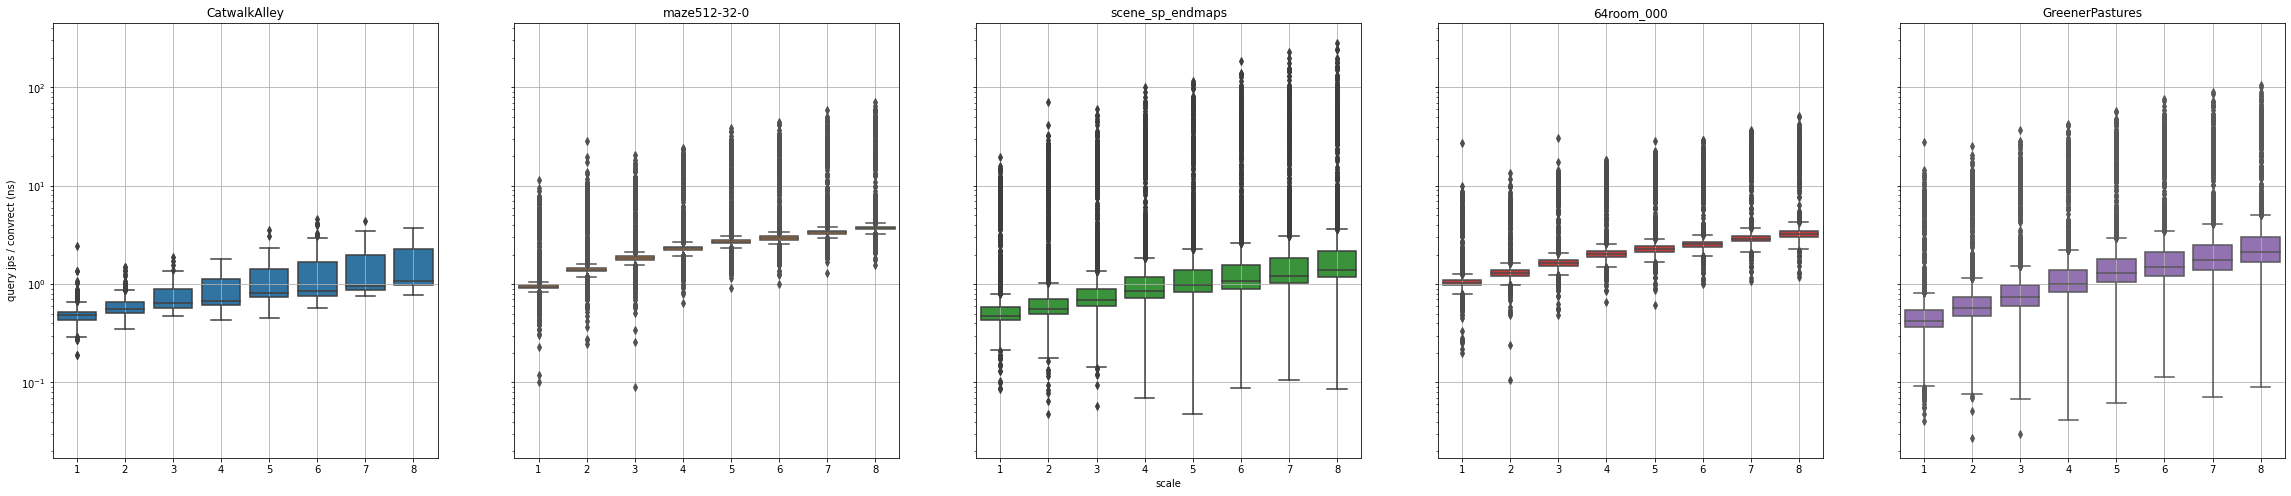

In [61]:
t = df[df["alg"] == "convrect"][["nano_ratio", "map", "scale"]]
names = t["map"].unique()
# names = t["domain"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=True, sharey=True, figsize=(8*num, 8))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    # sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["domain"] == names[i]], ax=axes[i])
    sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])

axes[0].set_ylabel("query jps / convrect (ns)")
axes[num // 2].set_xlabel("scale")
plt.savefig("./output/figs/speed_convrect.png")

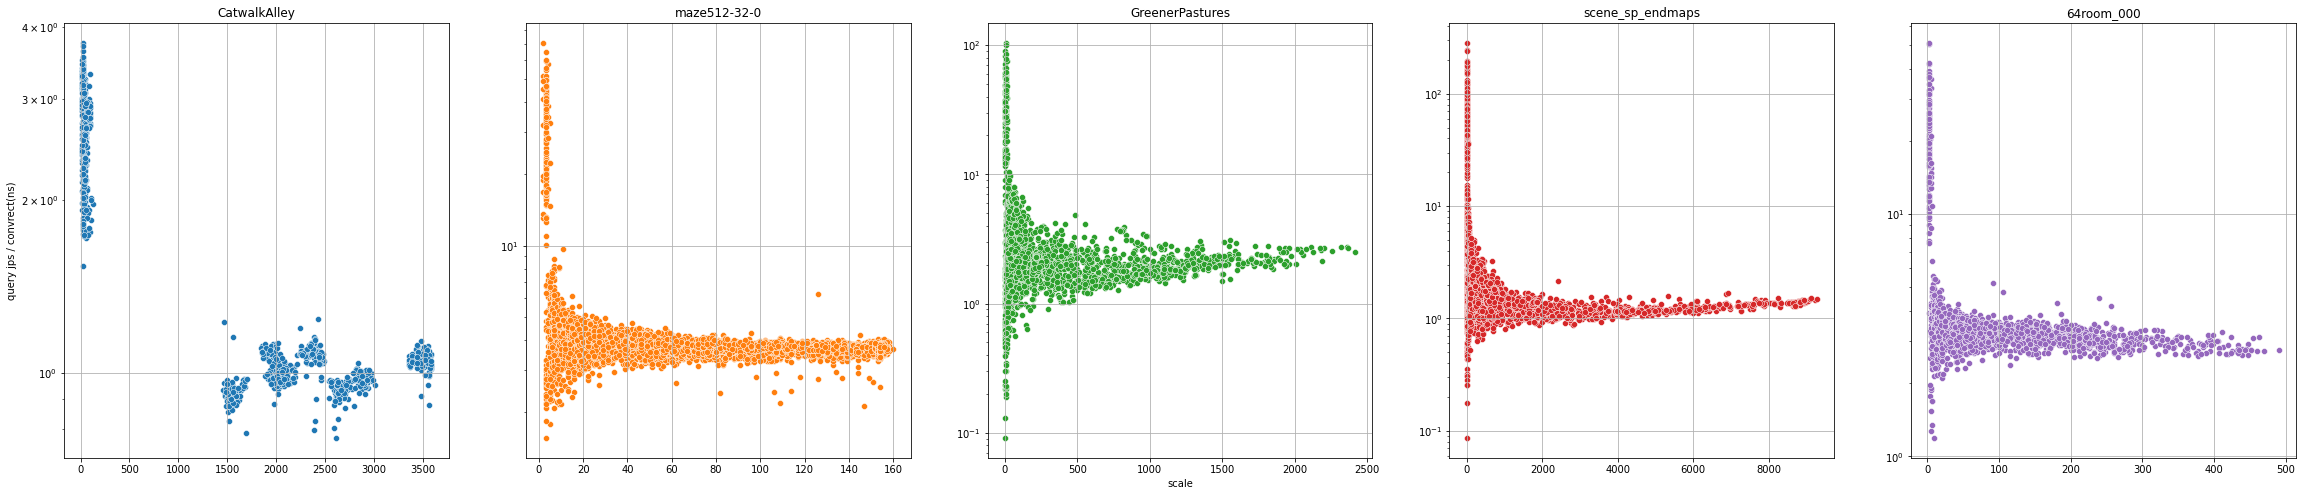

In [100]:
t = df[(df["alg"] == "convrect") & (df["scale"] == 8)][["nano_ratio", "map", "scale", "expanded_jps"]]
names = t["map"].unique()
num = len(names)
fig, axes = plt.subplots(1, num, sharex=False, sharey=False, figsize=(8*num, 8))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    sns.scatterplot(x="expanded_jps", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(names[i])

axes[0].set_ylabel("query jps / convrect(ns)")
axes[num // 2].set_xlabel("scale")
plt.savefig("./output/figs/dist_convrect.png")

# JPS+ vs Rect

In [3]:
# load query data
dname = "output/"
rfiles = [dname+"rect/"+i for i in os.listdir(dname+"rect")]
jfiles = [dname+"jpsp/"+i for i in os.listdir(dname+"jpsp")]
rect = pd.concat([load_df(i) for i in rfiles if os.stat(i).st_size])
jpsp = pd.concat([load_df(i) for i in jfiles if os.stat(i).st_size])

rfiles = [dname+"changed/rect/"+i for i in os.listdir(dname+"changed/rect")]
jfiles = [dname+"changed/jpsp/"+i for i in os.listdir(dname+"changed/jpsp")]
rectc = pd.concat([load_df(i) for i in rfiles if os.stat(i).st_size])
jpspc = pd.concat([load_df(i) for i in jfiles if os.stat(i).st_size])

load file: output/rect/maze512-32-0_6.log
load file: output/rect/scene_sp_endmaps_3.log
load file: output/rect/64room_000_7.log
load file: output/rect/GreenerPastures_4.log
load file: output/rect/Denver_2_1024_8.log
load file: output/rect/GreenerPastures_2.log
load file: output/rect/scene_sp_endmaps_5.log
load file: output/rect/64room_000_1.log
load file: output/rect/64room_000_6.log
load file: output/rect/maze512-32-0_1.log
load file: output/rect/GreenerPastures_5.log
load file: output/rect/64room_000_5.log
load file: output/rect/scene_sp_endmaps_1.log
load file: output/rect/maze512-32-0_8.log
load file: output/rect/maze512-32-0_2.log
load file: output/rect/scene_sp_endmaps_6.log
load file: output/rect/64room_000_4.log
load file: output/rect/GreenerPastures_3.log
load file: output/rect/GreenerPastures_8.log
load file: output/rect/Denver_2_1024_2.log
load file: output/rect/maze512-32-0_7.log
load file: output/rect/scene_sp_cha_02_1.log
load file: output/rect/scene_sp_endmaps_2.log
load

In [25]:
t1 = pd.merge(rect, jpsp, on=["map", "scale", "id", "domain"], suffixes=["_rect", "_jpsp"])
(t1["pcost_rect"]-t1["pcost_jpsp"]).describe()

count    54702.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [5]:
t2 = pd.merge(rectc, jpspc, on=["map", "scale", "id", "domain"], suffixes=["_rect", "_jpsp"])
(t2["pcost_rect"] - t2["pcost_jpsp"]).describe()

count    54702.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [474]:
t1.groupby(["map", "scale"])[["nanos_rect", "nanos_jpsp"]].describe().round(2).drop(columns=
    [("nanos_rect", "count"), ("nanos_rect", "std"), ("nanos_jpsp", "count"), ("nanos_jpsp", "std")])

nanos_rect                                       \
                            mean    min      25%       50%        75%   
map             scale                                                   
64room_000      1       21173.53  120.0   6107.0   15718.0    30464.0   
                2       24971.68  157.0   6439.0   22200.0    37869.0   
                8       26215.07  290.0   7377.0   18870.0    39784.0   
AR0044SR        1        6411.19  116.0   4287.0    6202.0     7940.0   
                2        6471.53  127.0   4384.0    6467.0     8792.0   
                8        6922.14  224.0   4372.0    6151.0     8532.0   
Denver_2_1024   1       51400.27  163.0  15263.0   27673.0    66688.5   
                2       53265.90  219.0  16794.0   29155.0    74826.5   
                8       72085.38  277.0  21570.5   38637.0    97664.5   
GreenerPastures 1      141003.33  123.0  20471.0   47039.0   184710.0   
                2      229036.07  146.0  32250.0   71529.0   307060.0   
                8      453147.03  318.0  51898.0  136864.0   608675.0   
maze512-32-0    1       69604.10  122.0  31045.0   72137.0   106176.0   
                2       29255.86  131.0  13999.0   31894.0    42037.0   
                8       39733.14  284.0  19784.0   39437.0    54724.0   
scene_sp_cha_02 1      194445.16  158.0  16105.0   42076.0   298686.0   
                2      344456.00  143.0  25200.0   65027.0   557570.5   
                8      743278.29  232.0  47427.0  144655.0  1182955.0   

                                 nanos_jpsp                                    \
                             max       mean    min     25%      50%       75%   
map             scale                                                           
64room_000      1       499744.0    9574.32  241.0  3274.0   7148.0   14177.0   
                2       129027.0   15145.94  410.0  5399.0  11373.0   21363.0   
                8       129781.0   18318.62  513.0  5186.0  10091.0   23465.0   
AR0044SR        1        55950.0    1825.65  242.0   940.0   1532.0    2235.0   
                2        63944.0    2293.24  310.0  1298.0   1951.0    2726.0   
                8        50719.0    2657.99  512.0  1553.0   2337.0    3353.0   
Denver_2_1024   1       442703.0   13416.82  444.0  3734.0   7550.0   20058.0   
                2       383601.0   14066.78  546.0  4125.5   8110.0   20384.5   
                8       428146.0   15376.62  648.0  4704.5   9420.0   22414.0   
GreenerPastures 1      1113270.0   42925.42  276.0  5033.0  16735.0   59580.0   
                2      1387220.0   47807.65  408.0  6208.0  19688.0   64309.0   
                8      3917080.0   54446.09  624.0  7335.0  21959.0   72588.0   
maze512-32-0    1       224257.0    9980.03  215.0  5708.0   9937.0   12541.0   
                2       134635.0    9014.91  382.0  4743.0   9629.0   12425.0   
                8       836833.0    9413.31  531.0  5440.0  10043.0   13005.0   
scene_sp_cha_02 1      1517200.0   68701.27  269.0  4621.0  20158.0   94970.5   
                2      2470180.0   77548.27  405.0  6367.5  21523.0  103462.0   
                8      4188350.0   88257.33  473.0  7139.5  24069.0  114324.0   

                                 
                            max  
map             scale            
64room_000      1       45732.0  
                2       79017.0  
                8      158557.0  
AR0044SR        1       23287.0  
                2       27811.0  
                8       29617.0  
Denver_2_1024   1      103356.0  
                2      211162.0  
                8      126749.0  
GreenerPastures 1      337564.0  
                2      383493.0  
                8      395629.0  
maze512-32-0    1      428969.0  
                2       52437.0  
                8       54541.0  
scene_sp_cha_02 1      447566.0  
                2      486728.0  
                8      666737.0

In [363]:
t1.groupby(["map", "scale"])["nanos_rect"].mean() / t1.groupby(["map", "scale"])["nanos_jpsp"].mean()

map              scale
64room_000       1        2.211491
                 2        1.648737
                 8        1.431061
AR0044SR         1        3.511730
                 2        2.822004
                 8        2.604273
Denver_2_1024    1        3.831033
                 2        3.786644
                 8        4.687986
GreenerPastures  1        3.284845
                 2        4.790783
                 8        8.322858
maze512-32-0     1        6.974338
                 2        3.245274
                 8        4.220951
scene_sp_cha_02  1        2.830299
                 2        4.441827
                 8        8.421718
dtype: float64

In [364]:
t2.groupby(["map", "scale"])["nanos_rect"].mean() / t2.groupby(["map", "scale"])["nanos_jpsp"].mean()

map              scale
64room_000       1        1.254907
                 2        1.162435
                 8        1.436750
AR0044SR         1        1.115202
                 2        1.071495
                 8        1.654379
Denver_2_1024    1        1.440666
                 2        1.530441
                 8        3.164120
GreenerPastures  1        1.546998
                 2        1.475553
                 8        2.487234
maze512-32-0     1        1.303246
                 2        1.215431
                 8        1.441035
scene_sp_cha_02  1        1.510142
                 2        1.357357
                 8        1.813274
dtype: float64

In [240]:
(jpspc["nanos"] / jpsp["nanos"]).describe()

count    909252.000000
mean       1657.990894
std        6602.508114
min           0.001071
25%          13.545562
50%          86.490211
75%         623.304832
max      606492.220651
Name: nanos, dtype: float64

In [241]:
rect["nanos"].sum() / jpsp["nanos"].sum()

12.138242353417747

In [242]:
rectc["nanos"].sum() / jpspc["nanos"].sum()

1.8394894502527288

In [37]:
# load repair data
t = pd.read_csv("./repair_cost.log")
t1 = t[t["alg"] == "rect"]
t1["scale"] = t1.apply(lambda row: parse(row["map"], suffix=".rectid")[1], axis=1)
t1["map"] = t1.apply(lambda row: parse(row["map"], suffix=".rectid")[0], axis=1)
t2 = t[t["alg"] == "jpsp"]
t2["scale"] = t2.apply(lambda row: parse(row["map"], suffix=".rectid")[1], axis=1)
t2["map"] = t2.apply(lambda row: parse(row["map"], suffix=".rectid")[0], axis=1)
rep = pd.DataFrame.merge(t1.drop(columns=["alg"]), t2.drop(columns=["alg"]), on=["map", "num", "scale"], suffixes=["_rect", "_jpsp"])
rep["avg_rect"] = rep["cost_rect"] / rep["num"]
rep["avg_jpsp"] = rep["cost_jpsp"] / rep["num"]
rep["ratio"] = rep["cost_jpsp"] / rep["cost_rect"]
rep.round(2)

/tmp/ipykernel_9059/510386712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1["scale"] = t1.apply(lambda row: parse(row["map"], suffix=".rectid")[1], axis=1)
/tmp/ipykernel_9059/510386712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1["map"] = t1.apply(lambda row: parse(row["map"], suffix=".rectid")[0], axis=1)
/tmp/ipykernel_9059/510386712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,map,cost_rect,num,scale,cost_jpsp,avg_rect,avg_jpsp,ratio
0,GreenerPastures,5.723850e+07,2912,1,6.228810e+08,19656.08,2.139014e+05,10.88
1,GreenerPastures,2.555500e+08,10000,2,1.519420e+10,25555.00,1.519420e+06,59.46
2,GreenerPastures,6.233000e+09,10000,8,5.720220e+11,623300.00,5.720220e+07,91.77
3,scene_sp_cha_02,4.309060e+07,1698,1,2.608250e+08,25377.27,1.536072e+05,6.05
4,scene_sp_cha_02,1.620160e+08,6912,2,7.749870e+09,23439.81,1.121220e+06,47.83
5,scene_sp_cha_02,2.305650e+09,10000,8,2.382940e+11,230565.00,2.382940e+07,103.35
6,64room_000,3.897430e+07,2422,1,7.364890e+07,16091.78,3.040830e+04,1.89
7,64room_000,2.360920e+08,9807,2,1.017100e+09,24073.82,1.037116e+05,4.31
8,64room_000,3.450020e+09,10000,8,1.963040e+10,345002.00,1.963040e+06,5.69
9,maze512-32-0,5.238770e+07,2417,1,1.158740e+08,21674.68,4.794125e+04,2.21


In [7]:
def plot_cmp(mname, fig=None, ax=None, scale=8):
    trep  = rep[(rep["scale"]==scale) & (rep["map"] == mname)]
    trect  = rect[(rect["scale"] == scale) & (rect["map"] == mname)]
    trectc = rectc[(rectc["scale"] == scale) & (rectc["map"] == mname)]
    tjpsp  = jpsp[(jpsp["scale"] == scale) & (jpsp["map"] == mname)]
    tjpspc = jpspc[(jpspc["scale"] == scale) & (jpspc["map"] == mname)]
    num = 100000
    max_amortized_change = 10
    rectx = [float(i)/float(num)*max_amortized_change for i in range(num)]
    jpspx = rectx

    jpsp_rep = trep["avg_jpsp"].values[0]
    rect_rep = trep["avg_rect"].values[0]
    rect_lb = [trect["nanos"].mean()  + i*rect_rep for i in rectx]
    rect_ub = [trectc["nanos"].mean() + i*rect_rep for i in rectx]
    jpsp_lb = [tjpsp["nanos"].mean()  + i*jpsp_rep for i in rectx]
    jpsp_ub = [tjpspc["nanos"].mean() + i*jpsp_rep for i in rectx]

    colors = sns.color_palette()
    recty = [(rect_lb[i]+rect_ub[i])/2.0 for i in range(num)]
    jpspy = [(jpsp_lb[i]+jpsp_ub[i])/2.0 for i in range(num)]
    if fig is None:
        fig, ax = plt.subplots()
    ax.plot(rectx, recty, color=colors[1], label="rect")
    ax.plot(jpspx, jpspy, color=colors[0], label="jpsp")
    ax.fill_between(rectx, rect_lb, rect_ub, alpha=0.3, color=colors[1])
    ax.fill_between(jpspx, jpsp_lb, jpsp_ub, alpha=0.3, color=colors[0])
    ax.legend(["rect", "jpsp"], loc="lower right")
    ax.set(xscale="linear", yscale="log", title=mname)
    fig.savefig("./output/figs/jpsp_vs_rect_%s.png" % mname)
    return fig, ax

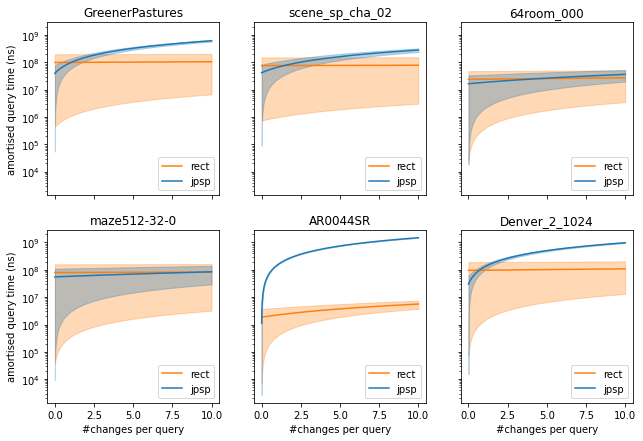

In [11]:
names = [
    "GreenerPastures", 
    "scene_sp_cha_02", 
    "64room_000", 
    "maze512-32-0", 
    "AR0044SR",
    "Denver_2_1024"
]
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(3.5*ncols, 3.5*nrows))
num = len(names)
for i in range(num):
    f, ax = plot_cmp(names[i], fig, axs[i//3][i%3], scale=8)
for i in range(nrows):
    axs[i][0].set(ylabel="amortised query time (ns)")
for i in range(ncols):
    axs[nrows-1][i].set(xlabel="#changes per query")
plt.savefig("./output/figs/jpsp_vs_rect.png")

# CCH vs JPS+ and Rect

In [27]:
dname = "./output/dimacs/"
ONE = 100000
cch = pd.concat([load_df(dname+i) for i in os.listdir(dname)])
cch["pcost"] /= ONE

load file: ./output/dimacs/64room_000_1.log
load file: ./output/dimacs/maze512-32-0_1.log
load file: ./output/dimacs/scene_sp_cha_02_1.log
load file: ./output/dimacs/Denver_2_1024_1.log
load file: ./output/dimacs/GreenerPastures_1.log
load file: ./output/dimacs/AR0044SR_1.log


In [28]:
cch.head()

,id,alg,nanos,extcost,pcost,plen,ref_dist,custcost,custnum,scnt,map,scale,domain
0,0,cch,38000,3000,4.24263,4,0,192831000,0,1,64room_000,1,rooms
1,1,cch,34000,2000,7.24263,7,0,192831000,0,1,64room_000,1,rooms
2,2,cch,39000,2000,5.41421,6,0,192831000,0,1,64room_000,1,rooms
3,3,cch,36000,1000,4.41421,5,0,192831000,0,1,64room_000,1,rooms
4,4,cch,29000,2000,6.82842,7,0,192831000,0,1,64room_000,1,rooms


In [30]:
# sanity checking
t = pd.merge(cch, jpsp, on=["map", "id", "domain", "scale"], suffixes=["_cch", "_jpsp"])
(t["pcost_cch"] - t["pcost_jpsp"]).describe()

count    18234.000000
mean         4.103106
std        463.365043
min      -1227.551070
25%         -5.514730
50%         -1.172630
75%         -0.000490
max      21102.728470
dtype: float64

In [32]:
# query performance
(t["nanos_cch"] / t["nanos_jpsp"]).describe()

count    18234.000000
mean       175.163662
std        388.491443
min          0.321597
25%         20.721396
50%         35.473899
75%        145.265923
max       4881.118881
dtype: float64

In [36]:
(t2["nanos_cch"] / t2["nanos_rect"]).describe()

count    18234.000000
mean       190.845944
std        952.392484
min          0.102368
25%          3.562280
50%          9.463917
75%         40.184772
max      16153.409091
dtype: float64

In [60]:
dname = "./output/dimacs/"
rep_log = [dname+i for i in os.listdir(dname) if i.endswith(".repair_log")]
dfs = []
from io import StringIO
for log in rep_log:
    with open(log, "r") as f:
        lines = f.readlines()[-2:]
        s = "".join(lines)
        data = StringIO(s)
        dfs.append(pd.read_csv(data, sep='\t'))
cch_rep = pd.concat(dfs)

cch_rep["scale"] = cch_rep.apply(lambda row: parse(row["map"], suffix=".diff")[1], axis=1)
cch_rep["map"] = cch_rep.apply(lambda row: parse(row["map"], suffix=".diff")[0], axis=1)
cch_rep["domain"] = cch_rep.apply(lambda row: dm_info.get(row["map"], "unknow"), axis=1)
cch_rep["normal"] *= 1000
cch_rep["partial"] *= 1000
cch_rep["sequential"] *= 1000
cch_rep.head()

,perturb_num,normal,partial,sequential,map,scale,domain
0,37612,259241000,192458000,224659000,64room_000,1,rooms
0,26372,595702000,1020512000,1345768000,scene_sp_cha_02,1,iron
0,36164,1463120000,3460213000,5029690000,AR0044SR,1,bgmaps
0,37590,340367000,303217000,360764000,maze512-32-0,1,maze512
0,124296,5206905000,13745975000,20237045000,Denver_2_1024,1,street


In [63]:
t = pd.merge(cch_rep, rep, on=["map", "scale"], suffixes=["_cch", ""])
t.head()

,perturb_num,normal,partial,sequential,map,scale,domain,cost_rect,num,cost_jpsp,avg_rect,avg_jpsp,ratio
0,37612,259241000,192458000,224659000,64room_000,1,rooms,38974300.0,2422,7.364890e+07,16091.783650,30408.298927,1.889679
1,26372,595702000,1020512000,1345768000,scene_sp_cha_02,1,iron,43090600.0,1698,2.608250e+08,25377.267373,153607.184923,6.052944
2,36164,1463120000,3460213000,5029690000,AR0044SR,1,bgmaps,37304400.0,2282,1.218670e+09,16347.239264,534035.933392,32.668264
3,37590,340367000,303217000,360764000,maze512-32-0,1,maze512,52387700.0,2417,1.158740e+08,21674.679355,47941.249483,2.211855
4,124296,5206905000,13745975000,20237045000,Denver_2_1024,1,street,170001000.0,7879,4.147940e+09,21576.469095,526455.133900,24.399504


In [64]:
(t["normal"] / t["cost_jpsp"]).describe()

count    6.000000
mean     2.258408
std      0.915138
min      1.200588
25%      1.512453
50%      2.318607
75%      2.791366
max      3.519958
dtype: float64

In [66]:
(t["sequential"] / t["cost_jpsp"]).describe()

count    6.000000
mean     4.456014
std      1.293448
min      3.050405
25%      3.366861
50%      4.503007
75%      5.089449
max      6.406586
dtype: float64

# Domain Experiment

In [416]:
dname = "nectar-output/"
rect_files = [dname+"rect/"+i for i in os.listdir(dname+"rect")]
jps2_files = [dname+"jps2/"+i for i in os.listdir(dname+"jps2")]
jps_files = [dname+"jps/"+i for i in os.listdir(dname+"jps")]
rect = pd.concat([load_df(i) for i in rect_files if os.stat(i).st_size])
jps2 = pd.concat([load_df(i) for i in jps2_files if os.stat(i).st_size])
jps = pd.concat([load_df(i) for i in jps_files if os.stat(i).st_size])

load file: nectar-output/rect/AR0308SR_6.log
load file: nectar-output/rect/orz102d_7.log
load file: nectar-output/rect/Milan_1_256_4.log
load file: nectar-output/rect/orz105d_5.log
load file: nectar-output/rect/Shanghai_2_256_8.log
load file: nectar-output/rect/brc505d_7.log
load file: nectar-output/rect/32room_003_1.log
load file: nectar-output/rect/maze512-4-5_3.log
load file: nectar-output/rect/isound1_3.log
load file: nectar-output/rect/maze512-4-8_7.log
load file: nectar-output/rect/AR0304SR_6.log
load file: nectar-output/rect/AR0601SR_4.log
load file: nectar-output/rect/BlackLotus_5.log
load file: nectar-output/rect/lak304d_4.log
load file: nectar-output/rect/NewYork_2_512_6.log
load file: nectar-output/rect/scene_sp_sax_01_8.log
load file: nectar-output/rect/Paris_0_1024_4.log
load file: nectar-output/rect/den501d_1.log
load file: nectar-output/rect/Ramparts_1.log
load file: nectar-output/rect/lak513d_2.log
load file: nectar-output/rect/AR0204SR_5.log
load file: nectar-output/re

In [417]:
t = jps[["id", "alg", "map", "domain", "scale", "expanded", "nanos", "pcost"]]
t1 = pd.DataFrame.merge(rect, t, on=["id", "map", "domain", "scale"], suffixes=("", "_jps"))
t2 = pd.DataFrame.merge(jps, t, on=["id", "map", "domain", "scale"], suffixes=("", "_jps"))
df = pd.concat([t1, t2])

df["expd_nano"] = df["nanos"] / df["expanded"]
df["expd_ratio"] = df["expanded_jps"] / df["expanded"]
df["nano_ratio"] = df["nanos_jps"] / df["nanos"]
# sanity checking
(df["pcost"] - df["pcost_jps"]).describe()

count    22977504.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
dtype: float64

In [418]:
df[["alg", "scale", "domain", "expd_nano"]].head()

,alg,scale,domain,expd_nano
0,rect,6,bgmaps,1723.000000
1,rect,6,bgmaps,11728.666667
2,rect,6,bgmaps,722.000000
3,rect,6,bgmaps,812.000000
4,rect,6,bgmaps,460.000000


/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/eggeek/.local/lib/python3.10/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


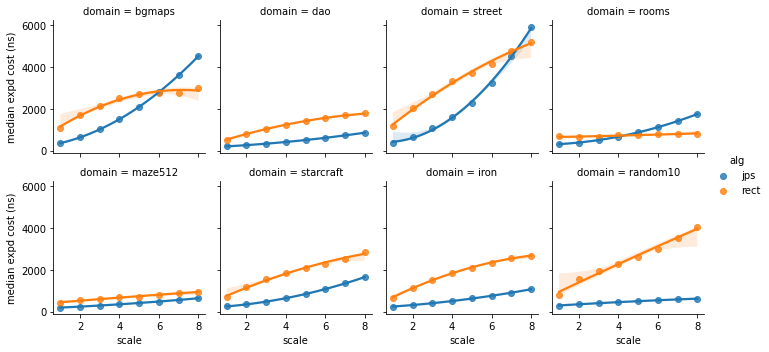

In [487]:
x = df.groupby(["alg", "scale", "domain"])["expd_nano"].describe().round(2).reset_index()
order = ["bgmaps", "dao", "street", "rooms", "maze512", "starcraft", "iron", "random10"]
g=sns.lmplot(data=x, x="scale", y="50%", order=2, hue="alg", col="domain", col_wrap=4, height=2.5, aspect=1, col_order=order)
g.set_ylabels("median expd cost (ns)")
plt.savefig("./output/figs/domain_expd_cost_scale.png")

In [165]:
t = df[(df["alg"] == "rect") & (df["scale"] <= 1)][["nanos", "map", "scale", "nanos_jps", "domain"]]
z = t.groupby(["map", "domain", "scale"]).sum()
z["total_ratio"] = z["nanos_jps"] / z["nanos"]
z[z["total_ratio"] > 1].sort_values("total_ratio", ascending=False).head(20)

,,,nanos,nanos_jps,total_ratio
map,domain,scale,,,
AR0044SR,bgmaps,1,10825096.0,23931640.0,2.210755
AR0042SR,bgmaps,1,12341128.0,20618120.0,1.670684
oth999d,dao,1,73146.0,118694.0,1.622700
64room_008,rooms,1,36829960.0,56285216.0,1.528245
64room_009,rooms,1,41445704.0,62386856.0,1.505267
64room_004,rooms,1,51700108.0,76570592.0,1.481053
64room_003,rooms,1,48238648.0,71338780.0,1.478872
64room_001,rooms,1,36570224.0,54015188.0,1.477026
64room_006,rooms,1,45714056.0,67103928.0,1.467906


In [166]:
t = df[df["alg"] == "rect"].groupby(["map", "scale", "domain"])

In [167]:
tot = pd.DataFrame(t.groups.keys(), columns=["map", "scale", "domain"]).groupby(["domain", "scale"]).count()
tot

map
domain scale     
bgmaps 1       75
       2       75
       3       75
       4       75
       5       75
...           ...
street 4       90
       5       90
       6       90
       7       90
       8       90

[64 rows x 1 columns]

In [168]:
# which map get better improvement on rect jps
z = df[df["alg"] == "rect"][["nano_ratio", "map", "scale", "domain"]].groupby(["map", "scale", "domain"]).describe()

In [171]:
t = z[z[("nano_ratio", "50%")] > 1]
z = t.reset_index()[["map", "domain", "scale"]].groupby(["domain", "scale"]).count()
z["perc"] = z["map"] / tot["map"] * 100.0
z

/home/eggeek/.local/lib/python3.10/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


map        perc
                               
domain    scale                
bgmaps    1       7    9.333333
          2      18   24.000000
          3      37   49.333333
          4      50   66.666667
          5      57   76.000000
          6      66   88.000000
          7      71   94.666667
          8      72   96.000000
dao       1       9    5.769231
          2       6    3.846154
          3       7    4.487179
          4      12    7.692308
          5      18   11.538462
          6      29   18.589744
          7      53   33.974359
          8      82   52.564103
iron      5       3    8.571429
          6       4   11.428571
          7       9   25.714286
          8      16   45.714286
maze512   2      10   16.666667
          3      20   33.333333
          4      20   33.333333
          5      30   50.000000
          6      30   50.000000
          7      30   50.000000
          8      30   50.000000
random10  2       1   10.000000
          3       4   40.000000
          4       5   50.000000
rooms     1      10   33.333333
          2      20   66.666667
          3      30  100.000000
          4      30  100.000000
          5      30  100.000000
          6      30  100.000000
          7      30  100.000000
          8      30  100.000000
starcraft 3       1    1.333333
          4       3    4.000000
          5      24   32.000000
          6      46   61.333333
          7      59   78.666667
          8      67   89.333333
street    1       4    4.444444
          2      11   12.222222
          3      25   27.777778
          4      38   42.222222
          5      49   54.444444
          6      63   70.000000
          7      69   76.666667
          8      78   86.666667

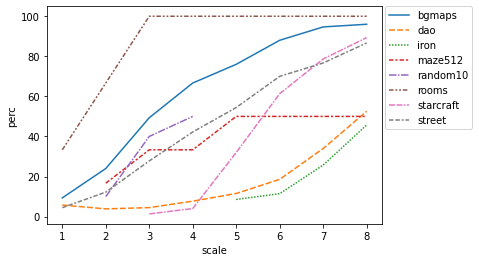

In [211]:
# g=sns.lmplot(data=z.reset_index(), x="scale", y="perc", col="domain", col_wrap=4, sharex="col", sharey="row")
# g.set(ylim=(0, 110.0))

# g=sns.relplot(data=z.reset_index(), x="scale", y="perc", col="domain", col_wrap=4, kind="line")
sns.lineplot(data=z.reset_index(), x="scale", y="perc", hue="domain", style="domain")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [226]:
df["domain"].unique()

array(['bgmaps', 'dao', 'street', 'rooms', 'maze512', 'starcraft', 'iron',
       'random10'], dtype=object)

In [291]:
t = df[df["domain"] == "starcraft"][["nanos", "nanos_jps", "map", "scale"]]
t = t.groupby(["map", "scale"]).sum()
t["ratio"] = t["nanos_jps"] / t["nanos"]
t.head()


nanos     nanos_jps     ratio
map           scale                                      
AcrosstheCape 1      9.823466e+08  8.427797e+08  0.857925
              2      1.561741e+09  1.279529e+09  0.819296
              3      2.151393e+09  1.812583e+09  0.842516
              4      2.788994e+09  2.692851e+09  0.965528
              5      3.170169e+09  3.255854e+09  1.027029

In [292]:
t.sort_values("ratio", ascending=False).head(20)

,,nanos,nanos_jps,ratio
map,scale,,,
GreenerPastures,8,4.406341e+09,6.252422e+09,1.418960
SpringThaw,8,1.497813e+10,2.096521e+10,1.399722
BigGameHunters,8,7.346852e+08,1.024276e+09,1.394169
Isolation,8,1.997071e+09,2.676972e+09,1.340449
SpringThaw,7,1.275011e+10,1.699397e+10,1.332849
Tribes,7,1.734477e+09,2.303103e+09,1.327837
GreenerPastures,7,3.802307e+09,4.979619e+09,1.309631
IceMountain,8,1.160610e+10,1.508860e+10,1.300058
Caldera,8,8.773853e+08,1.139621e+09,1.298883


In [426]:
df["alg"].unique()

array(['rect', 'jps'], dtype=object)

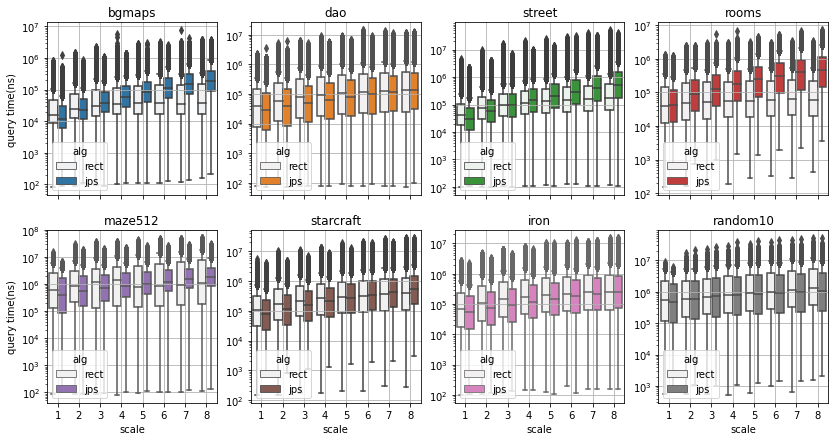

In [480]:
t = df[["nanos", "map", "scale", "domain", "alg"]]
names = t["domain"].unique()
num = len(names)
nrows = 2
ncols = num // nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(3.5*ncols, 3.5*nrows))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    axi = axes[i // ncols][i % ncols]
    g = sns.boxplot(x="scale", y="nanos", hue="alg", color=colors[i], data=t[t["domain"] == names[i]], ax=axi)
    sns.move_legend(g, "lower left")

    # plt.legend(loc="upper left", title="alg")

    axi.grid()
    axi.set_yscale("log")
    axi.set_xlabel("")
    axi.set_ylabel("")
    axi.set_title(names[i])

for i in range(nrows):
    axes[i][0].set_ylabel("query time(ns)")
for i in range(ncols):
    axes[nrows-1][i].set_xlabel("scale")
plt.savefig("./output/figs/domain_time_rect.png")

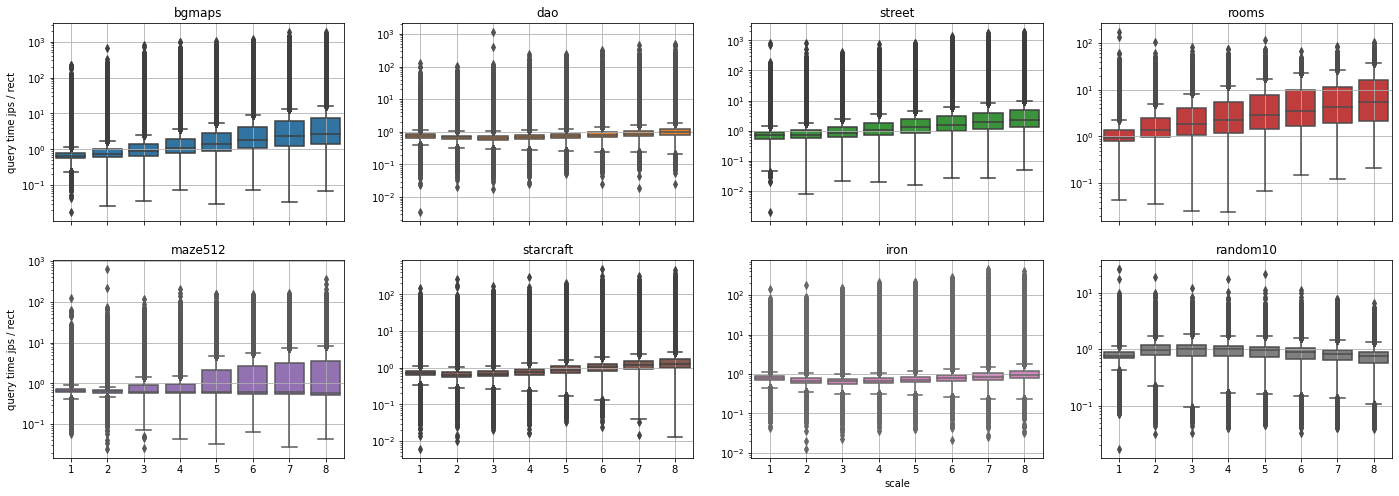

In [440]:
t = df[df["alg"] == "rect"][["nano_ratio", "map", "scale", "domain"]]
names = t["domain"].unique()
num = len(names)
nrows = 2
ncols = num // nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(6*ncols, 4*nrows))
if num == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(num):
    axi = axes[i // ncols][i % ncols]
    sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["domain"] == names[i]], ax=axi)
    # sns.boxplot(x="scale", y="nano_ratio", color=colors[i], data=t[t["map"] == names[i]], ax=axes[i])

    axi.grid()
    axi.set_yscale("log")
    axi.set_xlabel("")
    axi.set_ylabel("")
    axi.set_title(names[i])

for i in range(nrows):
    axes[i][0].set_ylabel("query time jps / rect")
axes[nrows-1][ncols // 2].set_xlabel("scale")
plt.savefig("./output/figs/domain_speed_rect.png")

Text(0.5, 0, 'rect expd')

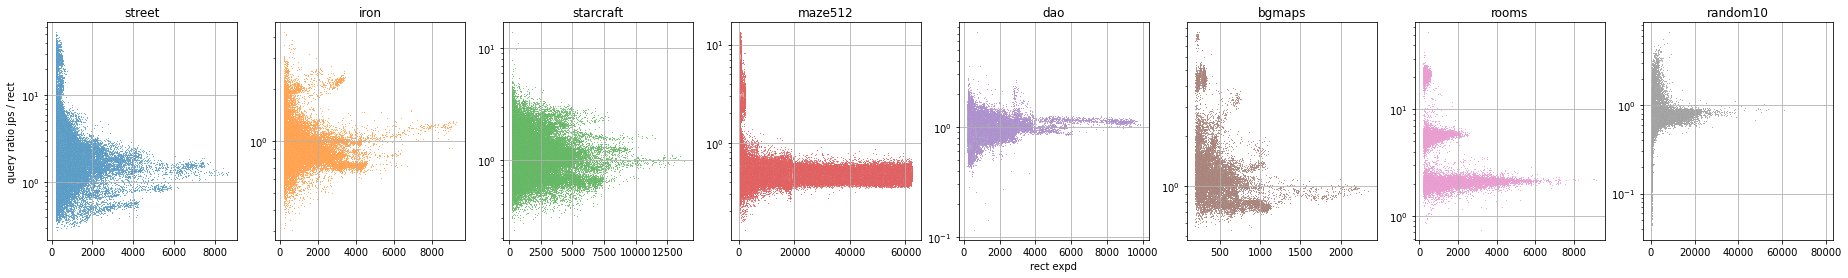

In [213]:
t = df[(df["alg"] == "rect") & (df["scale"] == 8)][["nano_ratio", "map", "scale", "domain", "expanded_jps"]]

domains = t["domain"].unique()
ndomain = len(domains)
minexpd = 200
mincost = 100
fig, axes = plt.subplots(1, ndomain, sharey=False, figsize=(4*ndomain, 4))
if ndomain == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(ndomain):
    g = t[t["domain"] == domains[i]]
    g = g[g["expanded_jps"] > minexpd]
    sns.scatterplot(x="expanded_jps", y="nano_ratio", color=colors[i], data=g, ax=axes[i], s=1)

    axes[i].grid()
    axes[i].set_yscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(domains[i])

axes[0].set_ylabel("query ratio jps / rect")
axes[ndomain // 2].set_xlabel("rect expd")

# Rectangle distribution


In [7]:
r = pd.read_csv("data/rect.distribution")
r["scale"] = r["map"].apply(lambda x: int(x.removesuffix(".rectid").split('_')[-1]))
r["map"] = r["map"].apply(lambda x: x.removesuffix(".rectid").split("/")[-1].split('_')[-2])
r["area"] = r["rw"] * r["rh"]
r["ratiow"] = (r["rw"] / r["ggmapw"])
r["ratioh"] = r["rh"] / r["maph"]
r["ratio_area"] = r["area"] / (r["mapw"] * r["maph"])
r.head()

,map,mapw,maph,rnum,rid,rw,rh,scale,area,ratiow,ratioh,ratio_area
0,arena,49,49,38,0,12,47,1,564,0.244898,0.959184,0.234902
1,arena,49,49,38,1,12,47,1,564,0.244898,0.959184,0.234902
2,arena,49,49,38,2,12,36,1,432,0.244898,0.734694,0.179925
3,arena,49,49,38,3,9,7,1,63,0.183673,0.142857,0.026239
4,arena,49,49,38,4,8,7,1,56,0.163265,0.142857,0.023324


In [6]:
r["map"].unique()

array(['arena', '000', 'endmaps', 'GreenerPastures', 'CatwalkAlley'],
      dtype=object)

In [8]:
z = r[r["area"]>=1024].groupby(["map", "scale"])[["rh", "rw", "area"]].describe(percentiles=[.75, .95, .98, .99]).T.round(3)
z

map            000                                                          \
scale            1        2        3        4        5         6         7   
rh   count    62.0     62.0     62.0     62.0     62.0      62.0      62.0   
     mean     63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     std       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
     min      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     50%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     75%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     95%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     98%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     99%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     max      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
rw   count    62.0     62.0     62.0     62.0     62.0      62.0      62.0   
     mean     63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     std       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
     min      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     50%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     75%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     95%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     98%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     99%      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
     max      63.0    126.0    189.0    252.0    315.0     378.0     441.0   
area count    62.0     62.0     62.0     62.0     62.0      62.0      62.0   
     mean   3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     std       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
     min    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     50%    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     75%    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     95%    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     98%    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     99%    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   
     max    3969.0  15876.0  35721.0  63504.0  99225.0  142884.0  194481.0   

map                  CatwalkAlley             ...      arena             \
scale              8            1          2  ...          7          8   
rh   count      62.0       28.000    151.000  ...     11.000     14.000   
     mean      504.0       52.107     55.748  ...    137.455    132.571   
     std         0.0       20.304     30.790  ...    109.221    119.845   
     min       504.0       29.000      8.000  ...     49.000     40.000   
     50%       504.0       52.000     48.000  ...     84.000     96.000   
     75%       504.0       57.250     58.000  ...    168.000     96.000   
     95%       504.0       97.650    110.000  ...    329.000    376.000   
     98%       504.0      105.920    144.000  ...    329.000    376.000   
     99%       504.0      106.460    189.000  ...    329.000    376.000   
     max       504.0      107.000    214.000  ...    329.000    376.000   
rw   count      62.0       28.000    151.000  ...     11.000     14.000   
     mean      504.0       58.107     59.219  ...     46.455     48.000   
     std         0.0       34.801     44.686  ...     28.395     30.260   
     min       504.0       20.000     18.000  ...     14.000     16.000   
     50%       504.0       47.500     46.000  ...     28.000     32.000   
     75%       504.0       72.250     58.000  ...     73.500     70.000   
     95%       504.0      132.650    145.000  ...     84.000     96.000   
     98%       504.0      133.000    226.000  ...     84.000     96.000   
   

In [18]:
z["CatwalkAlley"]

scale              1          2          3           4           5  \
rh   count    28.000    151.000    291.000     463.000     661.000   
     mean     52.107     55.748     61.959      65.650      67.655   
     std      20.304     30.790     40.803      49.247      56.339   
     min      29.000      8.000     12.000      16.000      15.000   
     50%      52.000     48.000     48.000      48.000      50.000   
     75%      57.250     58.000     73.500      76.000      75.000   
     95%      97.650    110.000    154.500     148.000     155.000   
     98%     105.920    144.000    175.200     211.040     260.000   
     99%     106.460    189.000    219.600     244.560     287.000   
     max     107.000    214.000    321.000     428.000     535.000   
rw   count    28.000    151.000    291.000     463.000     661.000   
     mean     58.107     59.219     65.825      69.408      72.216   
     std      34.801     44.686     54.253      62.229      68.883   
     min      20.000     18.000     12.000       8.000      10.000   
     50%      47.500     46.000     51.000      52.000      55.000   
     75%      72.250     58.000     72.000      76.000      80.000   
     95%     132.650    145.000    157.500     139.600     145.000   
     98%     133.000    226.000    254.400     258.080     269.000   
     99%     133.000    265.000    344.700     448.000     375.000   
     max     133.000    266.000    399.000     532.000     665.000   
area count    28.000    151.000    291.000     463.000     661.000   
     mean   2948.000   3813.695   5191.052    6302.860    7274.546   
     std    1943.049   5086.323   8957.551   13175.419   17673.121   
     min    1024.000   1024.000   1053.000    1024.000    1050.000   
     50%    2416.500   2052.000   2448.000    2592.000    2475.000   
     75%    2808.000   3248.000   4716.000    5776.000    5600.000   
     95%    6821.000  11124.000  20457.000   17856.000   21025.000   
     98%    7020.380  25536.000  30326.400   43260.160   61605.000   
     99%    7034.690  26984.000  57556.800   91120.640   70200.000   
     max    7049.000  28196.000  63441.000  112784.000  176225.000   

scale                6           7           8  
rh   count     848.000     972.000    1250.000  
     mean       69.842      75.092      74.234  
     std        63.321      71.141      75.169  
     min        18.000      14.000       8.000  
     50%        48.000      52.500      48.000  
     75%        78.000      84.000      80.000  
     95%       174.000     203.000     216.000  
     98%       306.000     323.120     288.160  
     99%       318.000     366.030     416.000  
     max       642.000     749.000     856.000  
rw   count     848.000     972.000    1250.000  
     mean       76.585      83.157      81.632  
     std        75.494      83.898      88.289  
     min        12.000      14.000       8.000  
     50%        54.000      56.000      64.000  
     75%        84.000      91.000      88.000  
     95%       168.000     189.000     200.000  
     98%       282.360     260.120     264.160  
     99%       412.260     445.060     432.000  
     max       798.000     931.000    1064.000  
area count     848.000     972.000    1250.000  
     mean     8429.307   10160.442   10565.888  
     std     22794.659   29179.688   33979.002  
     min      1080.000    1029.000    1024.000  
     50%      2592.000    2744.000    3072.000  
     75%      6336.000    7056.000    6848.000  
     95%     27777.600   34794.900   39139.200  
     98%     76304.880   91869.120   69730.560  
     99%     98298.000  132461.210  163954.560  
     max    253764.000  345401.000  451136.000

In [30]:
z = r[r["area"]>=1024].groupby(["map", "scale"])[["ratio_area"]].describe(percentiles=[.75, .95, .98, .99]).T

In [40]:
d = z.T

In [45]:
(d["ratio_area", "count"] * d["ratio_area", "mean"]).T

map              scale
000              1        0.938713
                 2        0.938713
                 3        0.938713
                 4        0.938713
                 5        0.938713
                 6        0.938713
                 7        0.938713
                 8        0.938713
CatwalkAlley     1        0.314880
                 2        0.549191
                 3        0.640274
                 4        0.695759
                 5        0.733715
                 6        0.757435
                 7        0.768852
                 8        0.787220
GreenerPastures  1        0.578300
                 2        0.664174
                 3        0.693512
                 4        0.709028
                 5        0.717939
                 6        0.726359
                 7        0.729098
                 8        0.731160
arena            2        0.649729
                 3        0.649729
                 4        0.649729
                 5        0.7792

# Rectangle visualisation

In [3]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv("output/rect.visual")
df["scale"] = 1
df["map"] = df["map"].apply(lambda x: x.removesuffix(".rectid").split("/")[-1].split('_')[-2])
df.head()

,map,maph,mapw,x,y,h,w,traversable,scale
0,arena,49,49,3,1,47,12,1,1
1,arena,49,49,35,1,47,12,1,1
2,arena,49,49,19,10,36,12,1,1
3,arena,49,49,26,3,7,9,1,1
4,arena,49,49,15,3,7,8,1,1


In [17]:
a = pd.read_csv("./cat0.visual")
a["map"] = "rect"
b = pd.read_csv("./cat0.convrect.visual")
b["map"] = "convrect"
df = pd.concat([a, b])
df.head()
df["scale"] = 1

In [19]:
df[(df["map"] == "arena") & (df["traversable"] == 1)].shape

(38, 9)

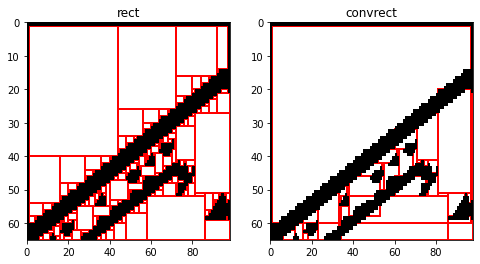

In [22]:
maps = df["map"].unique()
# maps = ["arena"]
nmap = len(maps)
fig, axes = plt.subplots(nrows=1, ncols=nmap, figsize=(nmap*4, 4))
if nmap == 1:
    axes = [axes]
for i, m in enumerate(maps):
    g = df[(df["map"] == m) & (df["scale"] == 1)]
    axes[i].set_xlim(0, g["mapw"].min())
    axes[i].set_ylim(0, g["maph"].min())
    axes[i].invert_yaxis()
    axes[i].set_title(m)
    # axes[i].scatter(x=g[g["traversable"] == 0]["x"], y=g[g["traversable"] == 0]["y"], c="black", s=20)

    for idx, row in g[g["traversable"] == 1].iterrows():
        # if row["w"] * row["h"] >= 32:
        axes[i].add_patch(Rectangle((row["x"], row["y"]), row["w"], row["h"], facecolor="none", edgecolor="red", linewidth=2))
    for idx, row in g[g["traversable"] == 0].iterrows():
        axes[i].add_patch(Rectangle((row["x"], row["y"]), row["w"], row["h"], facecolor="black", edgecolor="none"))

plt.savefig("./output/figs/rect_vs_convrect.pdf")

In [45]:
df = pd.read_csv("output/convrect.visual")
df["scale"] = 1
df["map"] = df["map"].apply(lambda x: x.removesuffix(".convrectid").split("/")[-1].split('_')[-2])
df.head()

,map,maph,mapw,x,y,h,w,traversable,scale
0,CatwalkAlley,512,512,219,0,72,126,1,1
1,CatwalkAlley,512,512,198,450,58,147,1,1
2,CatwalkAlley,512,512,379,0,53,133,1,1
3,CatwalkAlley,512,512,0,0,53,132,1,1
4,CatwalkAlley,512,512,379,456,52,133,1,1


In [50]:
df[(df["map"] == "CatwalkAlley") & (df["traversable"] == 0)].shape

(9603, 9)

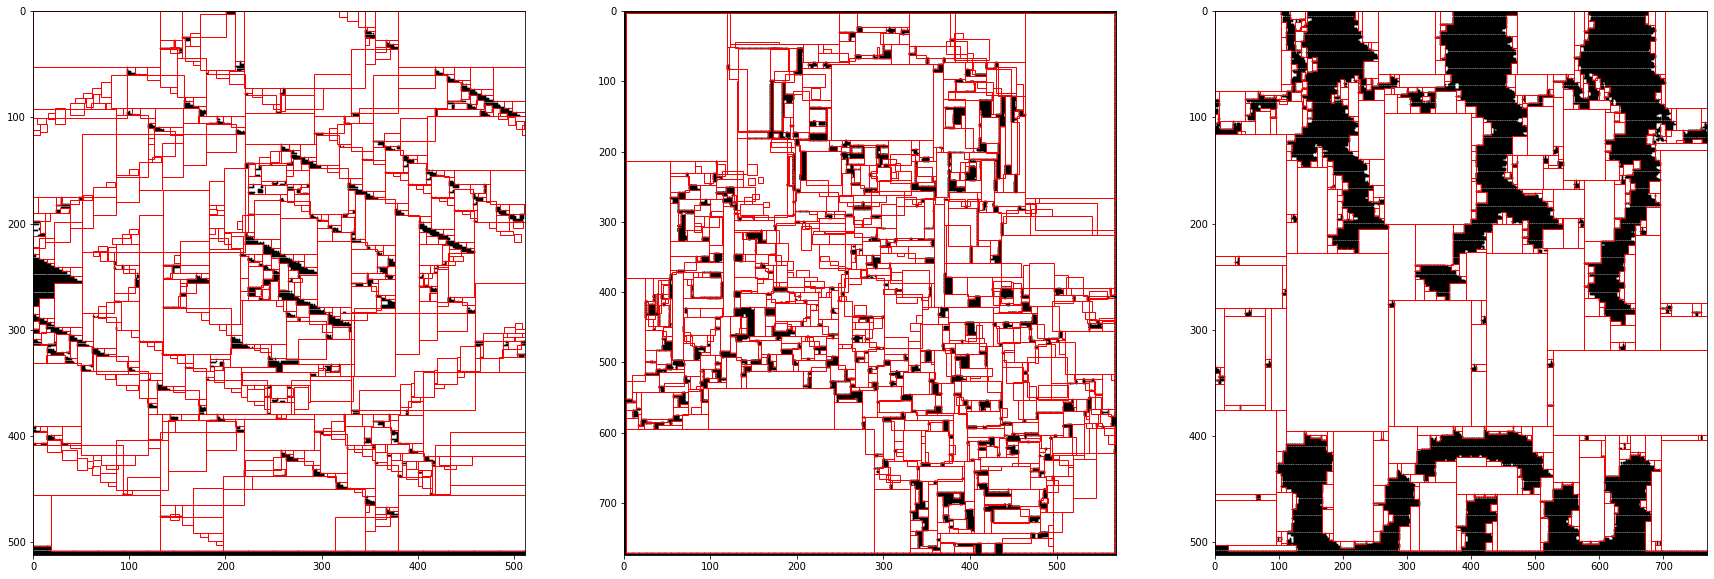

In [46]:
maps = df["map"].unique()
nmap = len(maps)
fig, axes = plt.subplots(nrows=1, ncols=nmap, figsize=(nmap*10, 10))
if nmap == 1:
    axes = [axes]
for i, m in enumerate(maps):
    g = df[(df["map"] == m) & (df["scale"] == 1)]
    axes[i].set_xlim(0, g["mapw"].min())
    axes[i].set_ylim(0, g["maph"].min())
    axes[i].invert_yaxis()
    axes[i].scatter(x=g[g["traversable"] == 0]["x"], y=g[g["traversable"] == 0]["y"], c="black", s=0.5)

    for idx, row in g[g["traversable"] == 1].iterrows():
        if row["w"] * row["h"] >= 32:
            axes[i].add_patch(Rectangle((row["x"], row["y"]), row["w"], row["h"], facecolor="none", edgecolor="red"))
plt.savefig("./output/figs/sample_convrect.png")

In [22]:
t = df[df["traversable"] == 1]
t["ratio"] = t["size"] / (t["maph"] * t["mapw"])

/tmp/ipykernel_260380/1433076558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["ratio"] = t["size"] / (t["maph"] * t["mapw"])


In [23]:
t.groupby("map")[["size", "ratio"]].describe().T.round(3)

map            Aurora  CatwalkAlley  GreenerPastures    arena    endmaps
size  count  4719.000      1986.000         1351.000   21.000   1565.000
      mean    104.635       113.763          219.281   97.810    234.584
      std     383.826       508.615         1153.242  169.750   1636.843
      min       1.000         1.000            1.000    2.000      1.000
      25%       2.000         2.000            3.000   12.000      8.000
      50%       5.000         7.000            9.000   25.000     39.000
      75%      34.000        33.000           45.000   49.000    146.000
      max    7231.000      8006.000        27490.000  564.000  50625.000
ratio count  4719.000      1986.000         1351.000   21.000   1565.000
      mean      0.000         0.000            0.001    0.041      0.001
      std       0.000         0.002            0.003    0.071      0.004
      min       0.000         0.000            0.000    0.001      0.000
      25%       0.000         0.000            0.000    0.005      0.000
      50%       0.000         0.000            0.000    0.010      0.000
      75%       0.000         0.000            0.000    0.020      0.000
      max       0.009         0.031            0.070    0.235      0.115